In [ ]:
!pip install -U tensorflow_addons

In [ ]:
# Common
import keras
import numpy as np
import tensorflow as tf
from tensorflow import image as tfi

# Data
from keras.datasets import cifar100

# Data Viz
import matplotlib.pyplot as plt

# Data Aug
from keras.layers import Normalization
from keras.layers import Resizing
from keras.layers import RandomFlip
from keras.layers import RandomRotation
from keras.layers import RandomZoom


# Model
from tensorflow.nn import gelu
from keras.models import Model
from keras.layers import Dense
from keras.layers import Layer
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import MultiHeadAttention
from keras.layers import LayerNormalization
from keras.layers import Add
from keras.layers import Flatten

# Compiling
from keras.losses import SparseCategoricalCrossentropy as SCCe
from tensorflow_addons.optimizers import AdamW
from keras.metrics import SparseCategoricalAccuracy as Acc
from keras.metrics import SparseTopKCategoricalAccuracy as KAcc

# Callbacks
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
def show_image(image, title=None, cmap=None):
    plt.imshow(image, cmap=cmap)
    if title is not None:
        plt.title(title)
    plt.axis('off')

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_custom_dataset(csv_file_path, class1_folder, class2_folder, test_size=0.2, random_state=42):
    # Read the CSV file
    data_df = pd.read_csv(csv_file_path)

    # Split the data into training and testing sets
    X_train_filenames, X_valid_filenames, y_train, y_valid = train_test_split(
        data_df['Path'].values,
        data_df['Label'].values,
        test_size=test_size,
        random_state=random_state,
        stratify=data_df['Label'].values  # Use stratified sampling if needed
    )

    # Function to load and preprocess images
    def load_images(folder, filenames):
        images = []
        for filename in filenames:
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            # Add any preprocessing steps if needed
            images.append(img)
        return np.array(images)

    # Load and preprocess images for training
    X_train = load_images(class1_folder, X_train_filenames)

    # Load and preprocess images for validation
    X_valid = load_images(class1_folder, X_valid_filenames)

    return (X_train, y_train), (X_valid, y_valid)

# Example usage
csv_file_path = '/content/drive/MyDrive/Histopathology /mixed_file1.csv'
class1_folder = '/content/drive/MyDrive/Histopathology /colon_image_sets/colaca33'
class2_folder = '/content/drive/MyDrive/Histopathology /colon_image_sets/coln44'

(X_train, y_train), (X_valid, y_valid) = load_custom_dataset(csv_file_path, class1_folder, class2_folder)

# Print the shape of the arrays to make sure everything is loaded correctly
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)


X_train shape: (1600, 768, 768, 3)
y_train shape: (1600,)
X_valid shape: (400, 768, 768, 3)
y_valid shape: (400,)


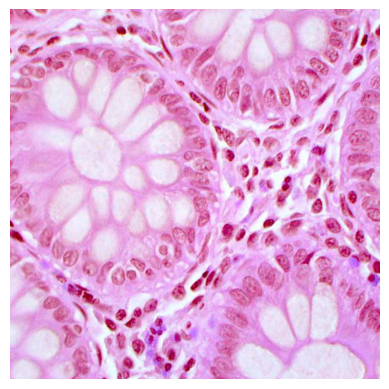

In [ ]:
image = X_train[np.random.randint(645)]
show_image(image)
plt.show()

In [ ]:
SIZE = 72
PATCH_SIZE = 6
LR = 0.001
WEIGHT_DECAY = 0.0001
EPOCHS = 60
NUM_PATCHES = (SIZE // PATCH_SIZE) ** 2
PROJECTION_DIMS = 64
NUM_HEADS = 4
HIDDEN_UNITS = [PROJECTION_DIMS*2, PROJECTION_DIMS]
OUTPUT_UNITS = [2048,1024]

In [ ]:
class DataAugmentation(Layer):
    def __init__(self, norm, SIZE):
        super(DataAugmentation, self).__init__()
        self.norm = norm
        self.SIZE = SIZE
        self.resize = Resizing(SIZE, SIZE)
        self.flip = RandomFlip('horizontal')
        self.rotation = RandomRotation(factor=0.02)
        self.zoom = RandomZoom(height_factor=0.2, width_factor=0.2)
    def call(self, X):
        x = self.norm(X)
        x = self.resize(x)
        x = self.flip(x)
        x = self.rotation(x)
        x = self.zoom(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
        "norm": self.norm,
        "SIZE": self.SIZE,
        })
        return config

In [ ]:
class Patches(Layer):

    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0] # Get the Batch Size
        patches = tfi.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1], # only along the Height and Width Dimension
            strides=[1, self.patch_size, self.patch_size, 1], # The next patch should not overlap the previus patch
            rates=[1,1,1,1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    def get_config(self):
        config = super().get_config()
        config.update({
            "path-size": self.patch_size,
        })
        return config

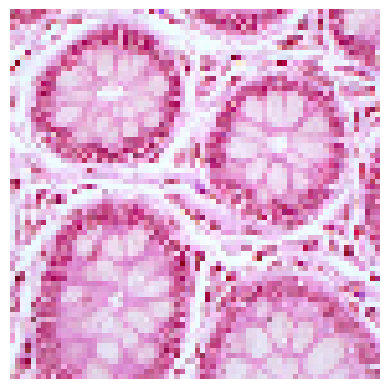

In [ ]:
image = X_train[np.random.randint(645)]
image = tfi.resize(image, (SIZE, SIZE))
image = tf.cast(image,'uint8')
show_image(image)
image = tf.expand_dims(image,0)

In [ ]:
patch = Patches(PATCH_SIZE) # patch Size
patches = patch(image)

In [ ]:
patches.shape # We needed 12 patches

TensorShape([1, 144, 108])

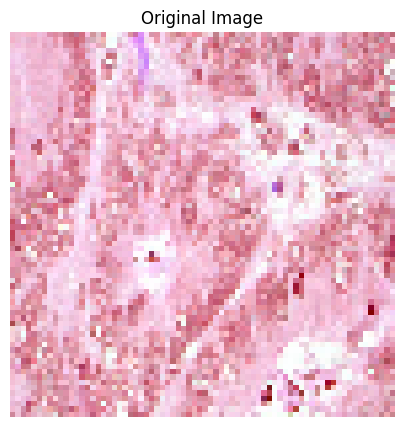

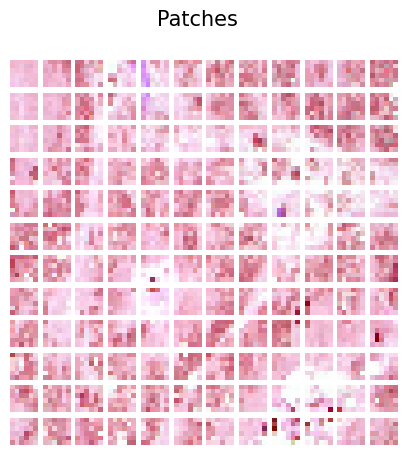

In [ ]:
plt.figure(figsize=(5,5))
show_image(image[0], title="Original Image")
plt.show()

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(5,5))
plt.suptitle("Patches", fontsize=15)
for i in range(patches.shape[-2]):
    plt.subplot(n,n,i+1)
    patch = tf.reshape(patches[0][i],(PATCH_SIZE, PATCH_SIZE, 3))
    patch = tf.cast(patch, 'uint8')
    show_image(patch, cmap='gray')
plt.show()

In [ ]:
class PatchEncoder(Layer):

    def __init__(self, num_patches, projection_dims): # Projection dims is  D
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.d = projection_dims

        self.dense = Dense(units=projection_dims)
        self.positional_embeddings = Embedding(input_dim=num_patches, output_dim=projection_dims)

    def call(self, X):
        positions = tf.range(0,limit=self.num_patches, delta=1)
        encoded = self.dense(X) + self.positional_embeddings(positions)
        return encoded
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_paches": self.num_patches,
            "d": self.d,
        })
        return config

In [ ]:
class MLP(Layer):
    def __init__(self, units, rate):
        super(MLP, self).__init__()
        self.units = units
        self.rate = rate
        self.layers = [[Dense(unit, activation=gelu), Dropout(rate)] for unit in units]

    def call(self, x):
        for layers in self.layers:
          for layer in layers:
            x = layer(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "units": self.units,
            "rate": self.rate,
        })
        return config

In [ ]:
class Transformer(Layer):

    def __init__(self, L, num_heads, key_dims, hidden_units):
        super(Transformer, self).__init__()
        self.L = L
        self.heads = num_heads
        self.key_dims = key_dims
        self.hidden_units = hidden_units

        self.norm = LayerNormalization(epsilon=1e-6) # Remember the Params
        self.MHA = MultiHeadAttention(num_heads=num_heads, key_dim=key_dims, dropout=0.1)
        self.net = MLP(units=hidden_units, rate=0.1)
        self.add= Add()

    def call(self, X):
        inputs = X
        x = X
        for _ in range(self.L):
          x = self.norm(x)
          x = self.MHA(x,x) # our Target and the Source element are the same
          y = self.add([x,inputs])
          x = self.norm(y)
          x = self.net(x)
          x = self.add([x,y])
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "L": self.L,
            "heads": self.heads,
            "key_dims":self.key_dims,
            "hidden_units":self.hidden_units
        })
        return config

In [ ]:
input_shape = X_train.shape[1:]
print(f'Input Image Shape : {input_shape}')

Input Image Shape : (768, 768, 3)


In [ ]:
# Input Layer
inputs = Input(shape=input_shape)

# Apply Data Aug
norm = Normalization()
norm.adapt(X_train)

x = DataAugmentation(norm, SIZE)(inputs)

# Get Patches
x = Patches(PATCH_SIZE)(x)

# PatchEncoding Network
x = PatchEncoder(NUM_PATCHES, PROJECTION_DIMS)(x)

# Transformer Network
x = Transformer(8, NUM_HEADS, PROJECTION_DIMS, HIDDEN_UNITS)(x)

# Output Network
x = LayerNormalization(epsilon=1e-6)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)

x = MLP(OUTPUT_UNITS, rate=0.5)(x)

# Ouput Layer
outputs = Dense(100)(x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768, 768, 3)]     0         
                                                                 
 data_augmentation (DataAug  (None, 72, 72, 3)         7         
 mentation)                                                      
                                                                 
 patches (Patches)           (None, None, 108)         0         
                                                                 
 patch_encoder (PatchEncode  (None, 144, 64)           16192     
 r)                                                              
                                                                 
 transformer (Transformer)   (None, 144, 64)           83072     
                                                                 
 layer_normalization_1 (Lay  (None, 144, 64)           128   

In [ ]:
with tf.device('/GPU:1'):
  # Model
  model = Model(
    inputs=[inputs],
    outputs=[outputs],
  )

  # Compiling
  model.compile(
      loss=SCCe(from_logits=True),
      optimizer=AdamW(learning_rate=LR, weight_decay=WEIGHT_DECAY),
      metrics=[
          Acc(name="Accuracy"),
          KAcc(5, name="Top-5-Accuracy")
      ]
  )

  # Callbacks

  # Fit
  results = model.fit(
      X_train, y_train,
      epochs=EPOCHS,
      validation_data=(X_valid, y_valid),

  )

Epoch 1/60
50/50 [==============================] - 18s 160ms/step - loss: 2.1092 - Accuracy: 0.6844 - Top-5-Accuracy: 0.9787 - val_loss: 1.2742 - val_Accuracy: 0.7500 - val_Top-5-Accuracy: 1.0000
Epoch 2/60
50/50 [==============================] - 6s 119ms/step - loss: 0.8905 - Accuracy: 0.7588 - Top-5-Accuracy: 1.0000 - val_loss: 0.3329 - val_Accuracy: 0.8575 - val_Top-5-Accuracy: 1.0000
Epoch 3/60
50/50 [==============================] - 4s 87ms/step - loss: 0.5096 - Accuracy: 0.7931 - Top-5-Accuracy: 1.0000 - val_loss: 0.3718 - val_Accuracy: 0.8200 - val_Top-5-Accuracy: 1.0000
Epoch 4/60
50/50 [==============================] - 5s 94ms/step - loss: 0.3581 - Accuracy: 0.8519 - Top-5-Accuracy: 1.0000 - val_loss: 0.3474 - val_Accuracy: 0.8600 - val_Top-5-Accuracy: 1.0000
Epoch 5/60
50/50 [==============================] - 6s 112ms/step - loss: 0.3028 - Accuracy: 0.8681 - Top-5-Accuracy: 1.0000 - val_loss: 0.3171 - val_Accuracy: 0.8500 - val_Top-5-Accuracy: 1.0000
Epoch 6/60
50/50 [===

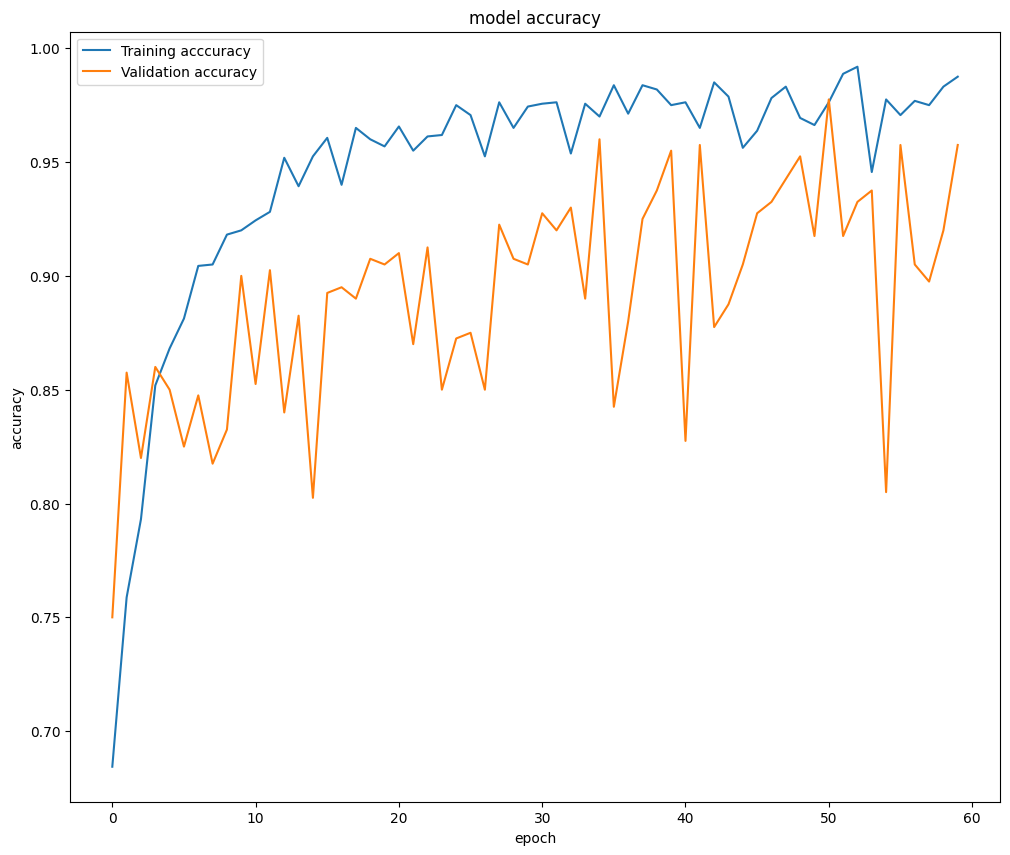

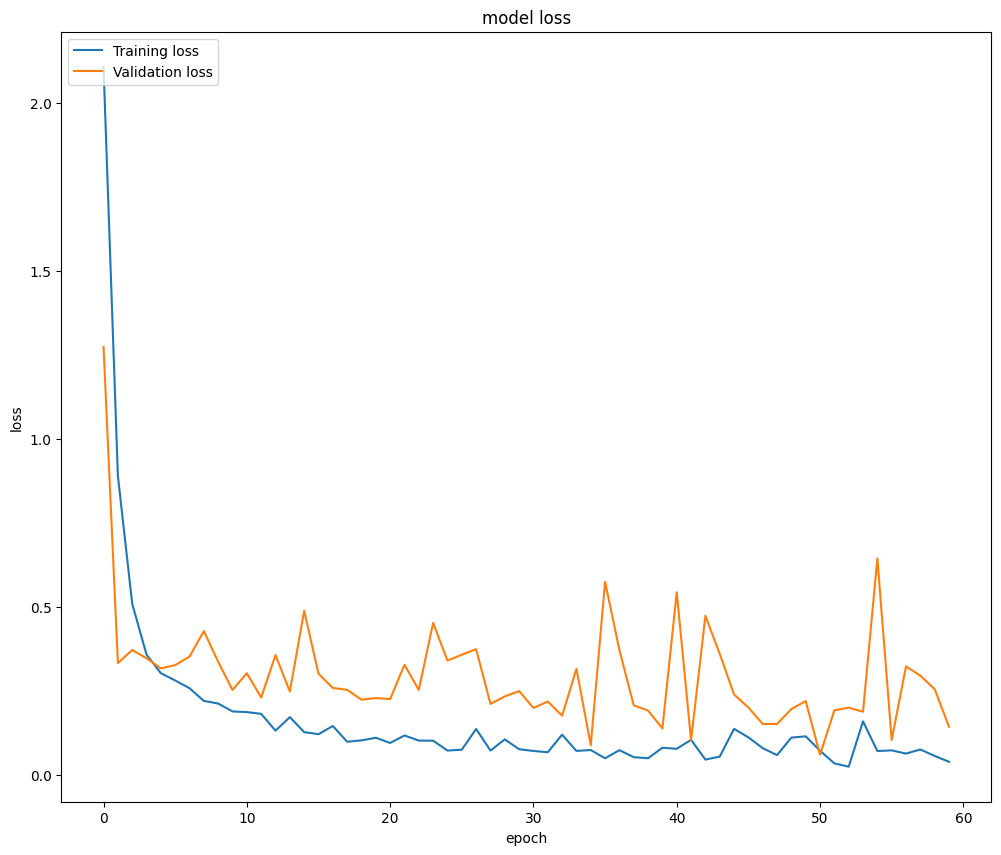

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(results.history['Accuracy'])
plt.plot(results.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training acccuracy', 'Validation accuracy'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(12,10))
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper left')
plt.show()

In [ ]:
y_pred=model.predict(X_valid)


13/13 [==============================] - 1s 57ms/step


In [ ]:
y_pred1=[]

In [ ]:
y_pred1 = []  # Initialize an empty list before the loop

for i in range(len(y_pred)):
    y_pred1.append(np.argmax(y_pred[i]))

# Now y_pred1 contains the argmax of each element in y_pred
print(y_pred1)


[0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 

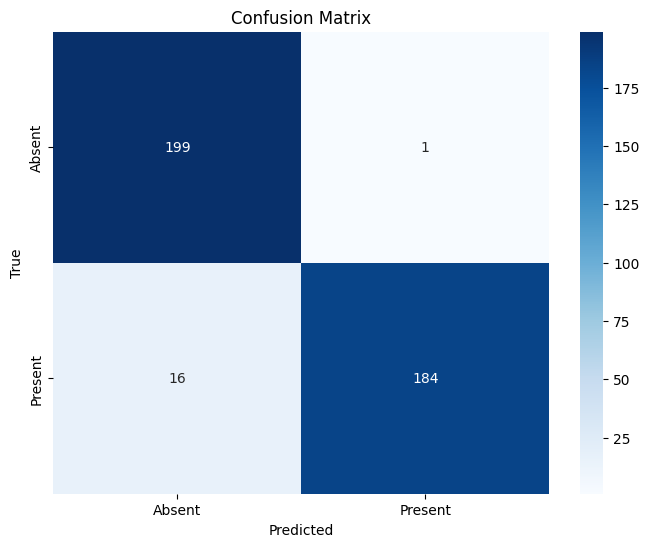

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Create confusion matrix
cm = confusion_matrix(y_valid, y_pred1)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Absent','Present'], yticklabels=['Absent','Present'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate classification metrics
accuracy = accuracy_score(y_valid, y_pred1)
precision = precision_score(y_valid, y_pred1)
recall = recall_score(y_valid, y_pred1)
f1 = f1_score(y_valid, y_pred1)
conf_matrix = confusion_matrix(y_valid, y_pred1)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.96
Precision: 0.99
Recall: 0.92
F1 Score: 0.96
Confusion Matrix:
[[199   1]
 [ 16 184]]


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_valid, y_pred1)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       200
           1       0.99      0.92      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



In [ ]:
model.save('/content/drive/MyDrive/Histopathology /VITtrans_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 31ms/step
Predicted class: Absent
input image: 


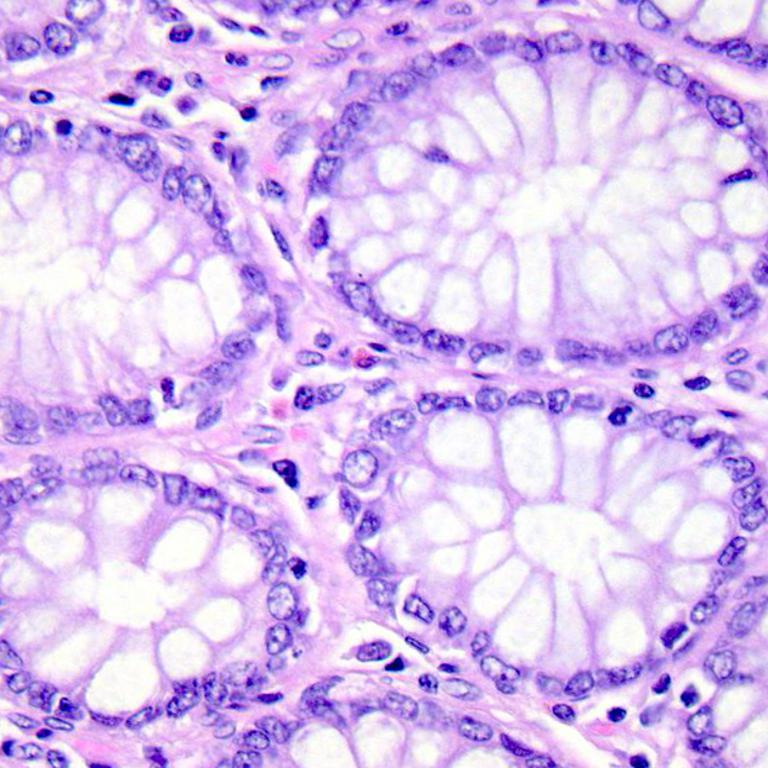

In [ ]:
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
class_labels = ['Absent','Present']

# Load input image with shape (224, 224, 3)
input_image_path = "/content/drive/MyDrive/Histopathology /colon_image_sets/coln44/colonn1012.jpeg"
input_image = cv2.imread(input_image_path)
input_image = cv2.resize(input_image, (768,768))  # Resize the image to match the expected input shape
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

# Get predictions
prediction = model.predict(input_image)
predicted_class = np.argmax(prediction)

# Print the predicted class label
print('Predicted class:', class_labels[predicted_class])

# Display the input image
print('input image: ')
input_image1 = cv2.imread(input_image_path)
cv2_imshow(input_image1)

1/1 [==============================] - 0s 46ms/step
Predicted class: Absent


(-0.5, 767.5, 767.5, -0.5)

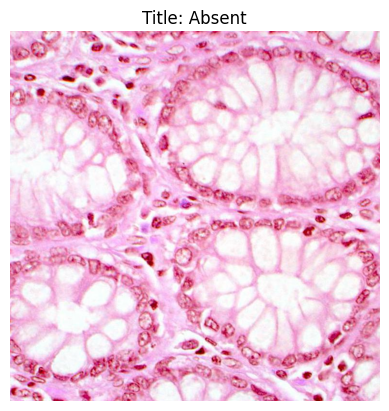

In [ ]:
from PIL import Image
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt

class_labels = ['Absent','Present']

# Load input image with shape (224, 224, 3)
input_image_path = "/content/drive/MyDrive/Histopathology /colon_image_sets/coln44/colonn1012.jpeg"
input_image= cv2.imread(input_image_path)
input_image = cv2.resize(input_image, (768,768))  # Resize the image to match the expected input shape
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
# Function to determine title based on the image path
def get_title(input_image_path):
    if "coln44" in input_image_path:
        return "Absent"
    else:
        return "Present"

# Get the title based on the image path
title = get_title(input_image_path)

# Get predictions
prediction = model.predict(input_image)
predicted_class = np.argmax(prediction)

# Print the predicted class label
print('Predicted class:', class_labels[predicted_class])
input_image1 = cv2.imread(input_image_path)
plt.imshow(input_image1)
plt.title(f"Title: {title}")
plt.axis("off")
#print(f"Title: {title}")


1/1 [==============================] - 0s 33ms/step
Predicted class: Present


(-0.5, 767.5, 767.5, -0.5)

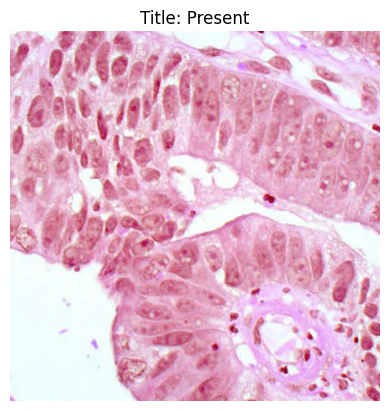

In [ ]:
from PIL import Image
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt

class_labels = ['Absent','Present']

# Load input image with shape (224, 224, 3)
input_image_path = "/content/drive/MyDrive/Histopathology /colon_image_sets/colaca33/colonca1002.jpeg"
input_image= cv2.imread(input_image_path)
input_image = cv2.resize(input_image, (768,768))  # Resize the image to match the expected input shape
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
# Function to determine title based on the image path
def get_title(input_image_path):
    if "coln44" in input_image_path:
        return "Absent"
    else:
        return "Present"

# Get the title based on the image path
title = get_title(input_image_path)

# Get predictions
prediction = model.predict(input_image)
predicted_class = np.argmax(prediction)

# Print the predicted class label
print('Predicted class:', class_labels[predicted_class])
input_image1 = cv2.imread(input_image_path)
plt.imshow(input_image1)
plt.title(f"Title: {title}")
plt.axis("off")
#print(f"Title: {title}")


In [ ]:
def get_img_array(img):

    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
def gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output,  model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
import matplotlib.cm as cm
def display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4, preds=0, plot=None):
    class_labels=["Absent","Present"]
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    plot.imshow(superimposed_img)
    plot.set(title="Predicted: {}".format(class_labels[preds]))


    plot.axis('off')

In [ ]:
model.layers[-1]

1/1 [==============================] - 0s 35ms/step
Absent:32.81557083129883
Present:16.79036521911621


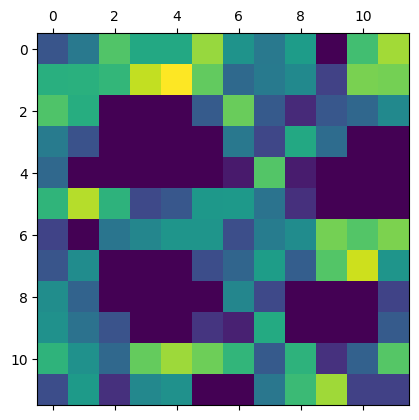

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/coln44/colonn1012.jpeg"
input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))

# Prepare image
img_array = get_img_array(resized_image)

last_conv_layer_name = 'layer_normalization_1'
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
print("Absent:{p1}\nPresent:{p2}".format(p1=preds[0][0], p2=preds[0][1]))

# Generate class activation heatmap
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)
heatmap = np.reshape(heatmap, (12,12))
# Display heatmap
cv2_imshow(heatmap)
plt.matshow(heatmap)
plt.axis('off')
plt.show()

In [ ]:
preds[0]

array([ -1.4799535,  21.132135 , -67.26436  , -66.6286   , -73.004814 ,
       -67.753784 , -70.55236  , -69.1209   , -58.741665 , -89.33263  ,
       -64.96419  , -58.929886 , -72.906685 , -59.75329  , -72.09842  ,
       -79.51203  , -73.51394  , -57.47135  , -77.141884 , -65.44683  ,
       -73.67827  , -61.02062  , -83.40247  , -73.617805 , -55.406597 ,
       -64.137054 , -72.3198   , -74.50285  , -68.36446  , -83.94313  ,
       -72.589516 , -76.64488  , -79.11851  , -55.366673 , -65.34992  ,
       -61.946068 , -60.65259  , -72.10916  , -79.463264 , -70.26164  ,
       -72.2618   , -69.35581  , -58.05326  , -65.32775  , -66.661674 ,
       -63.78305  , -81.97508  , -66.929085 , -69.43753  , -76.70055  ,
       -70.77053  , -57.50056  , -65.07384  , -60.1442   , -66.657555 ,
       -68.2777   , -78.51815  , -78.707466 , -72.05056  , -65.97245  ,
       -73.78074  , -75.480835 , -57.273598 , -76.17735  , -67.45576  ,
       -63.162735 , -68.961365 , -70.037224 , -79.4944   , -56.3

1/1 [==============================] - 0s 64ms/step


<ipython-input-88-a3aec37bf3aa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


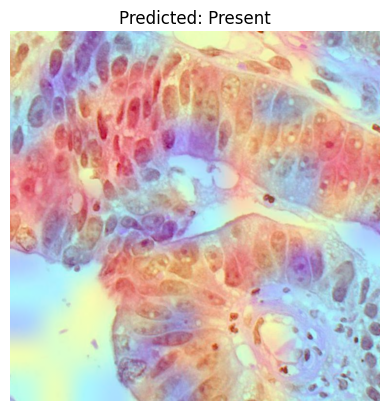

In [ ]:

class_labels=["Absent","Present"]
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/colaca33/colonca1002.jpeg"

input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))
# Prepare image
img_array = get_img_array(resized_image)
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
fig, ax = plt.subplots()
display_gradcam(resized_image, heatmap, preds=predicted_class, plot=ax)

In [ ]:
predicted_class = np.argmax(preds)

1

1/1 [==============================] - 0s 212ms/step


<ipython-input-88-a3aec37bf3aa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


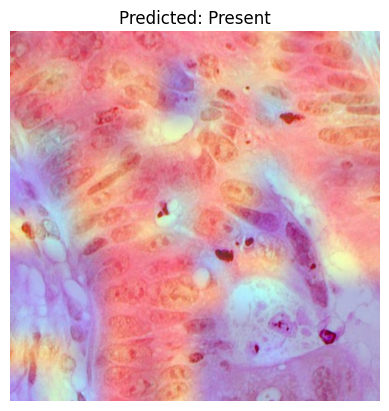

In [ ]:

class_labels=["Absent","Present"]
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/colaca33/colonca1058.jpeg"

input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))
# Prepare image
img_array = get_img_array(resized_image)
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
fig, ax = plt.subplots()
display_gradcam(resized_image, heatmap, preds=predicted_class, plot=ax)

1/1 [==============================] - 0s 84ms/step


<ipython-input-88-a3aec37bf3aa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


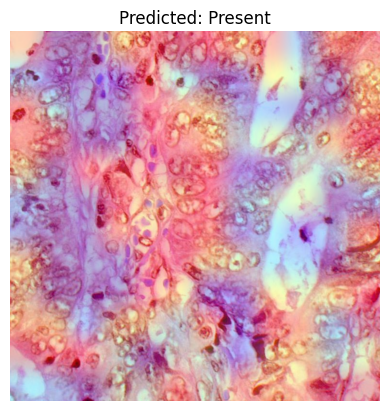

In [ ]:

class_labels=["Absent","Present"]
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/colaca33/colonca1102.jpeg"

input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))
# Prepare image
img_array = get_img_array(resized_image)
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
fig, ax = plt.subplots()
display_gradcam(resized_image, heatmap, preds=predicted_class, plot=ax)

1/1 [==============================] - 0s 68ms/step


<ipython-input-88-a3aec37bf3aa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


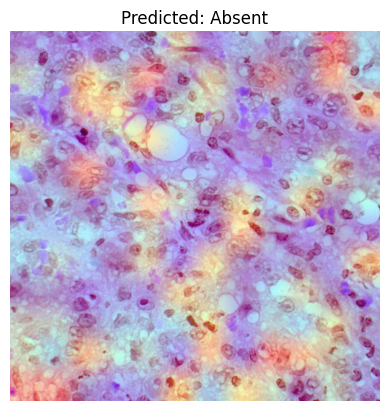

In [ ]:

class_labels=["Absent","Present"]
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/colaca33/colonca1554.jpeg"

input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))
# Prepare image
img_array = get_img_array(resized_image)
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
fig, ax = plt.subplots()
display_gradcam(resized_image, heatmap, preds=predicted_class, plot=ax)

1/1 [==============================] - 0s 75ms/step


<ipython-input-88-a3aec37bf3aa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


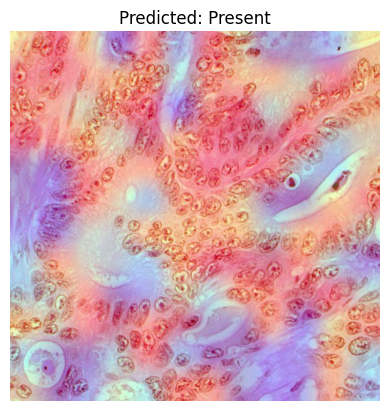

In [ ]:

class_labels=["Absent","Present"]
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/colaca33/colonca1459.jpeg"

input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))
# Prepare image
img_array = get_img_array(resized_image)
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
fig, ax = plt.subplots()
display_gradcam(resized_image, heatmap, preds=predicted_class, plot=ax)

1/1 [==============================] - 0s 52ms/step


<ipython-input-88-a3aec37bf3aa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


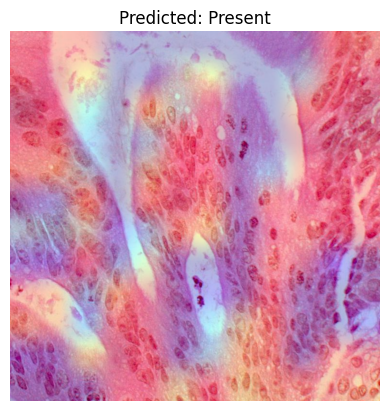

In [ ]:

class_labels=["Absent","Present"]
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/colaca33/colonca1387.jpeg"

input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))
# Prepare image
img_array = get_img_array(resized_image)
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
fig, ax = plt.subplots()
display_gradcam(resized_image, heatmap, preds=predicted_class, plot=ax)

1/1 [==============================] - 0s 53ms/step


<ipython-input-88-a3aec37bf3aa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


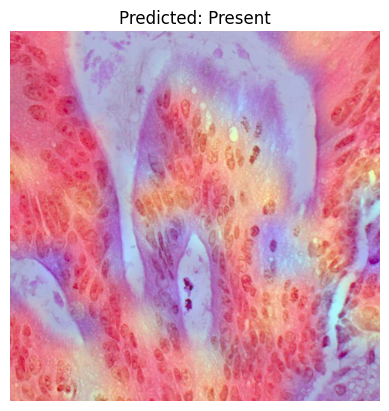

In [ ]:

class_labels=["Absent","Present"]
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/colaca33/colonca1277.jpeg"

input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))
# Prepare image
img_array = get_img_array(resized_image)
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
fig, ax = plt.subplots()
display_gradcam(resized_image, heatmap, preds=predicted_class, plot=ax)

1/1 [==============================] - 0s 50ms/step


<ipython-input-88-a3aec37bf3aa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


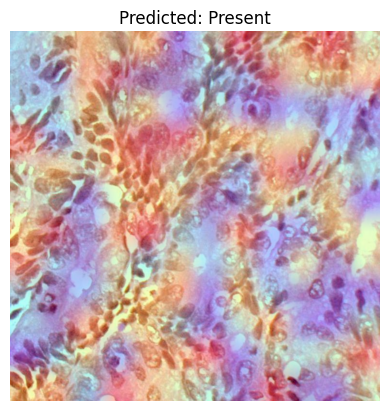

In [ ]:

class_labels=["Absent","Present"]
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/colaca33/colonca1205.jpeg"

input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))
# Prepare image
img_array = get_img_array(resized_image)
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
fig, ax = plt.subplots()
display_gradcam(resized_image, heatmap, preds=predicted_class, plot=ax)

1/1 [==============================] - 0s 33ms/step


<ipython-input-88-a3aec37bf3aa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


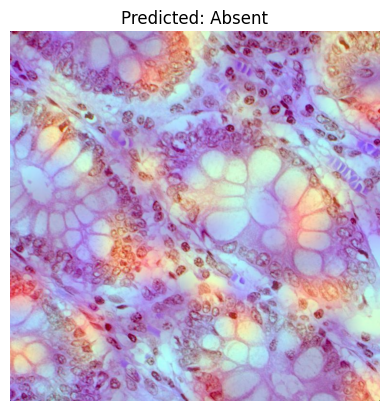

In [ ]:

class_labels=["Absent","Present"]
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/coln44/colonn1019.jpeg"

input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))
# Prepare image
img_array = get_img_array(resized_image)
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
fig, ax = plt.subplots()
display_gradcam(resized_image, heatmap, preds=predicted_class, plot=ax)

1/1 [==============================] - 0s 113ms/step


<ipython-input-88-a3aec37bf3aa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


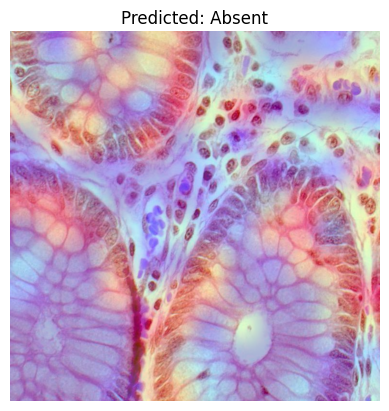

In [ ]:

class_labels=["Absent","Present"]
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/coln44/colonn1120.jpeg"

input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))
# Prepare image
img_array = get_img_array(resized_image)
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
fig, ax = plt.subplots()
display_gradcam(resized_image, heatmap, preds=predicted_class, plot=ax)

1/1 [==============================] - 0s 33ms/step


<ipython-input-88-a3aec37bf3aa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


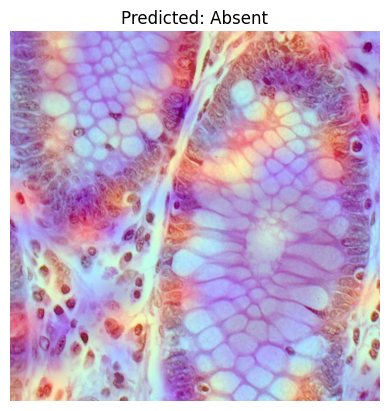

In [ ]:
class_labels=["Absent","Present"]
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/coln44/colonn1403.jpeg"

input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))
# Prepare image
img_array = get_img_array(resized_image)
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
fig, ax = plt.subplots()
display_gradcam(resized_image, heatmap, preds=predicted_class, plot=ax)

1/1 [==============================] - 0s 172ms/step


<ipython-input-88-a3aec37bf3aa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


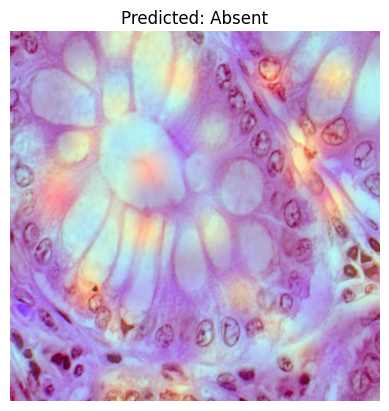

In [ ]:
class_labels=["Absent","Present"]
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/coln44/colonn1521.jpeg"

input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))
# Prepare image
img_array = get_img_array(resized_image)
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
fig, ax = plt.subplots()
display_gradcam(resized_image, heatmap, preds=predicted_class, plot=ax)

1/1 [==============================] - 0s 101ms/step


<ipython-input-88-a3aec37bf3aa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


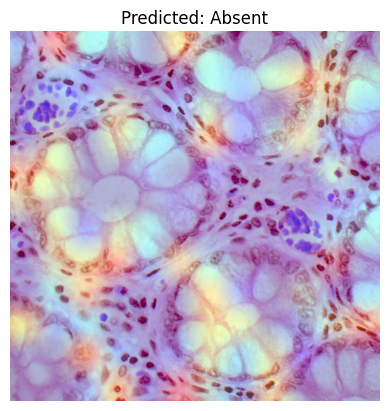

In [ ]:
class_labels=["Absent","Present"]
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/coln44/colonn1671.jpeg"

input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))
# Prepare image
img_array = get_img_array(resized_image)
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
fig, ax = plt.subplots()
display_gradcam(resized_image, heatmap, preds=predicted_class, plot=ax)

1/1 [==============================] - 0s 101ms/step


<ipython-input-88-a3aec37bf3aa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


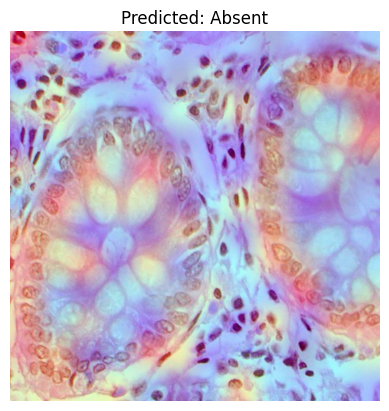

In [ ]:
class_labels=["Absent","Present"]
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/coln44/colonn1810.jpeg"

input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))
# Prepare image
img_array = get_img_array(resized_image)
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
fig, ax = plt.subplots()
display_gradcam(resized_image, heatmap, preds=predicted_class, plot=ax)

1/1 [==============================] - 0s 43ms/step


<ipython-input-88-a3aec37bf3aa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


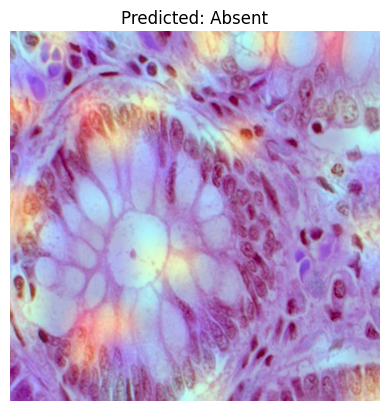

In [ ]:
class_labels=["Absent","Present"]
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/coln44/colonn1143.jpeg"

input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))
# Prepare image
img_array = get_img_array(resized_image)
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
fig, ax = plt.subplots()
display_gradcam(resized_image, heatmap, preds=predicted_class, plot=ax)

1/1 [==============================] - 0s 47ms/step


<ipython-input-88-a3aec37bf3aa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


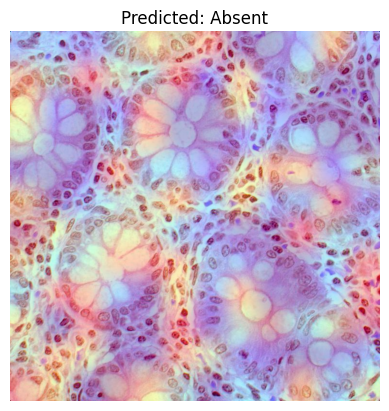

In [ ]:
class_labels=["Absent","Present"]
test_image = "/content/drive/MyDrive/Histopathology /colon_image_sets/coln44/colonn1324.jpeg"

input_image = cv2.imread(test_image)
resized_image = cv2.resize(input_image, (768,768))
# Prepare image
img_array = get_img_array(resized_image)
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
fig, ax = plt.subplots()
display_gradcam(resized_image, heatmap, preds=predicted_class, plot=ax)